---

## Problem Definition

Predict the performance of companies according to **`rating`** and **`work happiness score`**
- Analyze the `importance` of features help in increasing work happiness score.
- Predict the `rating` of companies
- Detect the `anomalies` of ratings.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

In [2]:
df = pd.read_pickle('../dataset/data_prepare2.pickle')
def change_obj_cols(se):
    value = se.unique().tolist()
    return se.map(pd.Series(range(len(value)), index = value)).values

df['industry'] = change_obj_cols(df['industry'])

---

### Split Dataset into Train & Test
Split the whole dataset into **`train`** and **`test`** datasets with the ratio 8 : 2.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

train, test = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = False)
train.to_excel('../dataset/train.xlsx', index = False)
test.to_excel('../dataset/test.xlsx', index = False)

---

# Machine Learning Models
1. OLS Linear Regression to predict `Work Happiness Score`
2. Neural Network on `rating`
3. Light GBM predicting `rating`

### Linear Regression

In [4]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
# import train/test set
train = pd.read_excel("../dataset/train.xlsx")
test = pd.read_excel("../dataset/test.xlsx")


In [6]:
# split sets into predictor and reponse sets
train_Happiness_X = train.drop(columns = ['name', 'Work Happiness Score','rating','reviews','ceo_count', 'roles', 'salary', 'industry'])
train_Happiness_y = pd.DataFrame(train['Work Happiness Score'])

test_Happiness_X = test.drop(columns = ['name','Work Happiness Score','rating','reviews','ceo_count', 'roles', 'salary', 'industry'])
test_Happiness_y = pd.DataFrame(test['Work Happiness Score'])

print("Train Set :", train_Happiness_X.shape, train_Happiness_y.shape)
print("Test Set  :", test_Happiness_X.shape, test_Happiness_y.shape)


Train Set : (2375, 9) (2375, 1)
Test Set  : (594, 9) (594, 1)


In [7]:
def univariateLinearRegression(X_train, X_test, y_train, y_test):
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model

    # Print the coefficients of the Regression Line
    print('Intercept \t: b = ', linreg.intercept_)
    print('Coefficients \t: a = ', linreg.coef_)
    
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Prediction Accuracy of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()

In [8]:
univariateLinearRegression(train_Happiness_X, test_Happiness_X, train_Happiness_y, test_Happiness_y)

Intercept 	: b =  [8.23261208]
Coefficients 	: a =  [[-1.97245334e-02 -2.20221906e-01 -2.72152797e-03  4.39750736e+00
  -9.70925495e-01 -3.92664897e+00  9.04559531e+00  8.53433568e+00
   1.35126070e-05]]
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6060022012491115
Mean Squared Error (MSE) 	: 31.21751187313104

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6302894905851715
Mean Squared Error (MSE) 	: 30.06239464331868



In [9]:
## creating function to get model statistics
import numpy as np
import statsmodels.api as sm
stepwise_train_happiness_x = train_Happiness_X
results = sm.OLS(train_Happiness_y, stepwise_train_happiness_x).fit()
print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Work Happiness Score   R-squared (uncentered):                   0.992
Model:                              OLS   Adj. R-squared (uncentered):              0.992
Method:                   Least Squares   F-statistic:                          3.247e+04
Date:                  Sat, 16 Apr 2022   Prob (F-statistic):                        0.00
Time:                          16:14:35   Log-Likelihood:                         -7481.1
No. Observations:                  2375   AIC:                                  1.498e+04
Df Residuals:                      2366   BIC:                                  1.503e+04
Df Model:                             9                                                  
Covariance Type:              nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
-------

### Light GBM model
Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

In [10]:
from sklearn.model_selection import KFold
import lightgbm as lgb
import datetime
import time

In [11]:
# import train/test set
target = train['rating']
train_rating_X = train.drop(columns = ['name', 'rating','reviews','ceo_count', 'roles', 'salary'])
features = [c for c in train_rating_X.columns]
categorical_feats = ['industry', 'revenue', 'employees']

In [12]:
# set the hyperparameters of the LGBM model
param = {'num_leavs' : 80,
         'min_data_in_leaf' : 90,
         'objective' : 'regression',
         'max_depth' : 5,
         'learning_rate' : 0.005,
         'boosting' : 'gbdt',
         'feature_fraction' : 0.7522,
         'bagging_freq' : 1,
         'bagging_fraction' : 0.7083,
         'bagging_seed' : 11,
         'metric' : 'rmse',
         'lambda_l1' : 0.2634,
         'random_state' : 133,
         'verbosity' : -1
        }

In [13]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
[LightGBM] [Warning] Unknown parameter: num_leavs
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.25887	valid_1's rmse: 0.284738
[200]	training's rmse: 0.180921	valid_1's rmse: 0.199913
[300]	training's rmse: 0.137478	valid_1's rmse: 0.150511
[400]	training's rmse: 0.114351	valid_1's rmse: 0.122463
[500]	training's rmse: 0.102386	valid_1's rmse: 0.106841
[600]	training's rmse: 0.0960019	valid_1's rmse: 0.0982612


D:\anaconda\envs\SC1015\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\envs\SC1015\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\anaconda\envs\SC1015\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\envs\SC1015\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Referen

[700]	training's rmse: 0.0925143	valid_1's rmse: 0.0933048
[800]	training's rmse: 0.0905418	valid_1's rmse: 0.0905014
[900]	training's rmse: 0.0892516	valid_1's rmse: 0.0888139
[1000]	training's rmse: 0.0883766	valid_1's rmse: 0.08781
[1100]	training's rmse: 0.0876642	valid_1's rmse: 0.0871234
[1200]	training's rmse: 0.0870966	valid_1's rmse: 0.0865886
[1300]	training's rmse: 0.0865754	valid_1's rmse: 0.0862294
[1400]	training's rmse: 0.0861075	valid_1's rmse: 0.0859781
[1500]	training's rmse: 0.0856402	valid_1's rmse: 0.0858592
[1600]	training's rmse: 0.0852037	valid_1's rmse: 0.0857191
[1700]	training's rmse: 0.0848041	valid_1's rmse: 0.0856101
[1800]	training's rmse: 0.0844154	valid_1's rmse: 0.0855403
[1900]	training's rmse: 0.084034	valid_1's rmse: 0.0854146
[2000]	training's rmse: 0.0836576	valid_1's rmse: 0.0852944
[2100]	training's rmse: 0.083308	valid_1's rmse: 0.0852536
[2200]	training's rmse: 0.082973	valid_1's rmse: 0.0852033
[2300]	training's rmse: 0.0826331	valid_1's rmse

In [14]:
print("Root Mean Squared Error (RMSE) \t: {}".format(mean_squared_error(predictions, test['rating'])**0.5))
print("Mean Absolute Error (MAE) \t: {}".format(mean_absolute_error(predictions, test['rating'])))


Root Mean Squared Error (RMSE) 	: 0.09016468137439741
Mean Absolute Error (MAE) 	: 0.06153731789400552


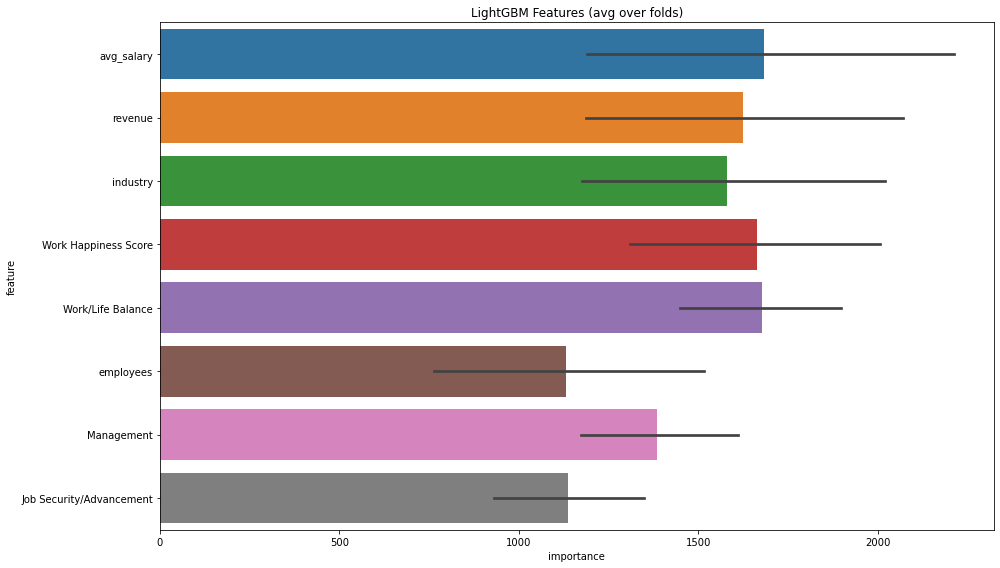

In [15]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[3:11].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 8))
sb.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

---
# Insights

### Find the `anomalies` of ratings among the companies.

In [16]:
df_anomalies = pd.DataFrame({"Company Name" : test["name"].values})
df_anomalies["real"] = test['rating']
df_anomalies["predict"] = predictions
df_anomalies['ratio'] = df_anomalies['predict'] / df_anomalies['real']

<AxesSubplot:xlabel='ratio', ylabel='Count'>

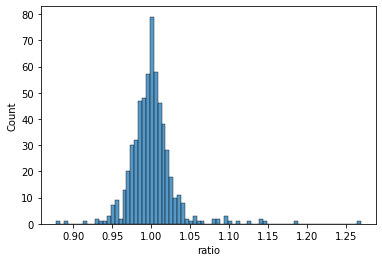

In [17]:
sb.histplot(df_anomalies['ratio'], binwidth = 0.005)

In [18]:
LL = df_anomalies['ratio'].quantile(0.05)
UL = df_anomalies['ratio'].quantile(0.95)
print("5% percentile of ratios : {}".format(LL))
print("95% percentile of ratios : {}".format(UL))
print("The 90% confidential interval is [{}, {}]".format(LL, UL))

5% percentile of ratios : 0.9641807318090925
95% percentile of ratios : 1.0387017134580818
The 90% confidential interval is [0.9641807318090925, 1.0387017134580818]


In [19]:
df_anomalies_L = df_anomalies[(df_anomalies['ratio'] < LL)]
df_anomalies_L

,Company Name,real,predict,ratio
9,"Med-Scribe, Inc",4.6,4.290295,0.932673
24,Team Fishel,3.3,3.181700,0.964152
31,Crystal Run Village,2.8,2.652276,0.947241
44,Encore Wire,3.4,3.256830,0.957891
52,The Reserves Network,3.3,3.121345,0.945862
67,"Weigels Stores | Weigels Stores, Inc.",3.0,2.860103,0.953368
76,Lamps Plus,3.5,3.211427,0.917550
88,CTI Foods,2.9,2.772268,0.955954
100,RestorixHealth,2.9,2.795980,0.964131
125,ServiceLink,3.0,2.807452,0.935817


In [20]:
df_anomalies_U = df_anomalies[(df_anomalies['ratio'] > UL)]
df_anomalies_U

,Company Name,real,predict,ratio
18,Enlivant,2.3,2.625824,1.141663
71,Primus Technologies,3.5,3.783688,1.081054
74,Emerson Ecologics,2.8,2.918809,1.042432
144,Sava Senior Care,2.5,2.655975,1.062390
177,American Marketing and Publishing,2.9,3.042597,1.049171
181,BlueGrace Logistics,2.8,3.088536,1.103049
182,Country Pure Foods,2.4,2.593188,1.080495
189,CARVANA,2.7,2.931029,1.085566
213,Trumpet Behavioral Health,3.1,3.228262,1.041375
227,Delek US Holdings,2.8,2.984384,1.065851
